In [1]:
%matplotlib inline

In [2]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

In [3]:
from envs.createEnvs import createNNEnv

env = createNNEnv()

Loading models...
Models loaded


In [4]:
# reset the environment to get the first observation
done = False
observation, _ = env.reset()

print(f'Initial observation: {observation}')

Initial observation: [4 0]


In [5]:
action = env.action_space.sample()

# execute the action in the environment and receive info
observation, reward, terminated, _, _ = env.step(action)

print(observation)


[4 1]


In [6]:
class GridWorldNNAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [7]:
# hyperparameters
learning_rate = 0.1
n_episodes = 850
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = GridWorldNNAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    obs = tuple(observation)

    done = False
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, _, _ = env.step(action)
        next_obs = tuple(next_obs)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 850/850 [17:59<00:00,  1.27s/it] 


## Visualizing the training




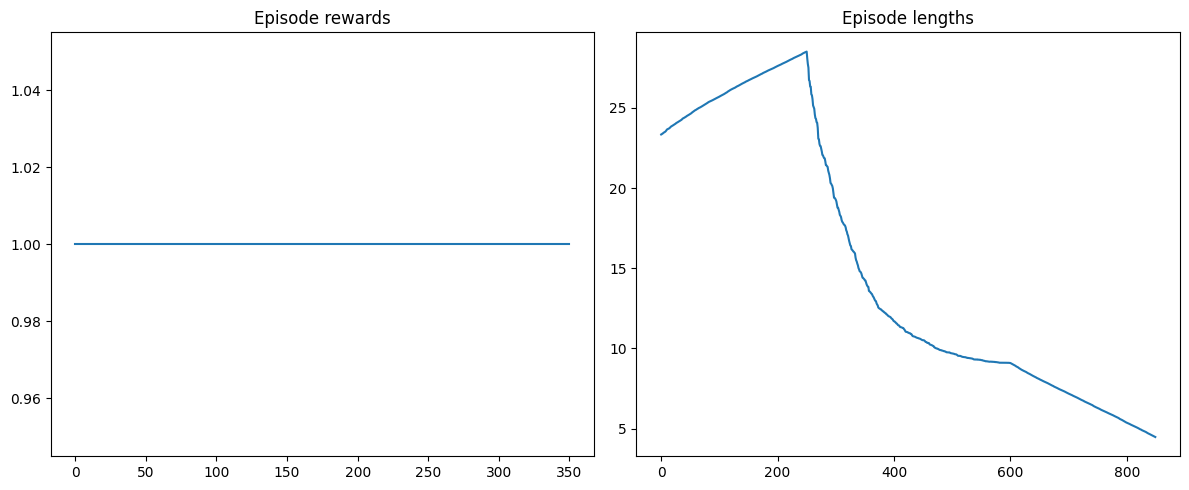

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)

axs[1].plot(range(len(length_moving_average)), length_moving_average)
"""axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)"""
plt.tight_layout()
plt.show()

## Visualising the policy



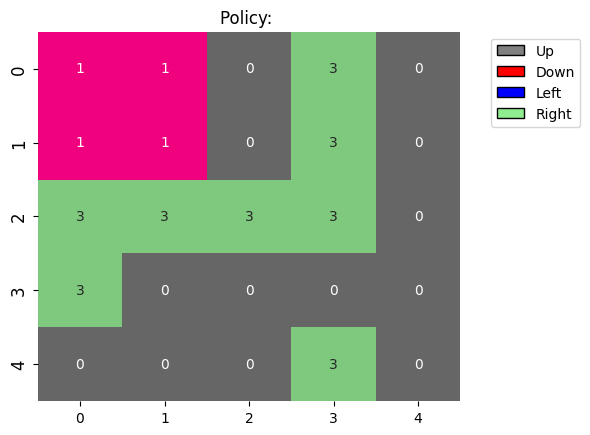

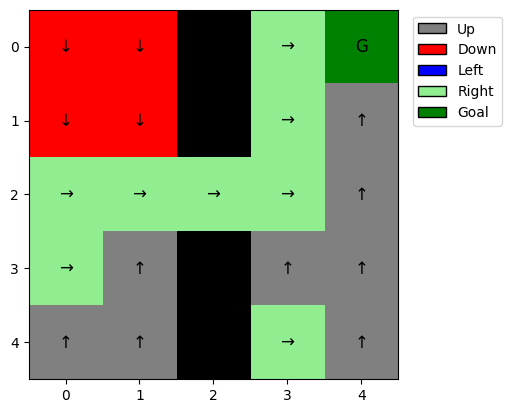

In [10]:
def create_grids(agent):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)

    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    # create a grid for the state values
    value_grid = np.zeros((5, 5))
    for obs, value in state_value.items():
        value_grid[obs] = value
    #print(value_grid)

    # create a grid for the policy. In each state we should show the action that has the highest int(np.argmax(action_values))
    policy_grid = np.zeros((5, 5))
    for obs, action in policy.items():
        policy_grid[obs] = action
    #print(policy_grid)

    #I want to turn policy grid into a grid made up of strings. I want to replace the numbers with arrows that represent the action
    # ACtion 0 = up, 1 = down, 2 = left, 3 = right. The grid must be a new grid made up of strings, because i cant cast a string to a float
    string_policy_grid = np.chararray((5,5), unicode=True)
    for i in range(5):
        for j in range(5):
            #Grid positions [0,2], [1,2], [3,2], [4,2] are walls, so we dont want to show an action for them, instead show an X. 
            #We also dont want to show an action for the goal, so we show a G in the grid position [0,4]
            if j == 2 and (i == 0 or i == 1 or i == 3 or i == 4):
                string_policy_grid[i][j] = 'X'
            elif i == 0 and j == 4:
                string_policy_grid[i][j] = 'G'
            elif policy_grid[i][j] == 0:
                string_policy_grid[i][j] = '↑'
            elif policy_grid[i][j] == 1:
                string_policy_grid[i][j] = '↓'
            elif policy_grid[i][j] == 2:
                string_policy_grid[i][j] = '←'
            elif policy_grid[i][j] == 3:
                string_policy_grid[i][j] = '→'
            else:
                string_policy_grid[i][j] = 'X'
    #print(string_policy_grid)

    return value_grid, policy_grid, string_policy_grid


def create_plots(value_grid, policy_grid, title=""):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)


    # add a legend
    legend_elements = [
        Patch(facecolor="gray", edgecolor="black", label="Wall"),
        Patch(facecolor="red", edgecolor="black", label="Goal"),
        Patch(facecolor="blue", edgecolor="black", label="Up"),
        Patch(facecolor="lightgreen", edgecolor="black", label="Down"),
        Patch(facecolor="yellow", edgecolor="black", label="Left"),
        Patch(facecolor="orange", edgecolor="black", label="Right"),
    ]

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)

    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.set_xticklabels(range(0, 5))
    ax2.set_yticklabels(list(range(0, 5)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="gray", edgecolor="black", label="Up"),
        Patch(facecolor="red", edgecolor="black", label="Down"),
        Patch(facecolor="blue", edgecolor="black", label="Left"),
        Patch(facecolor="lightgreen", edgecolor="black", label="Right"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    return fig



def create_plots_string(string_policy_grid):
    from matplotlib.colors import ListedColormap
    map_data = np.array(string_policy_grid)
    
    colors = ['red', 'black', 'lightgreen', 'green', 'gray']
    cmap = ListedColormap(colors)

    # Create an array of integers based on the character array
    numeric_map = np.zeros(map_data.shape, dtype=int)
    for i, char in enumerate(['↓', 'X', '→', 'G', '↑']):
        numeric_map[map_data == char] = i

    # Create the plot using imshow
    fig, ax = plt.subplots()
    im = ax.imshow(numeric_map, cmap=cmap, norm=plt.Normalize(0, len(colors)))

    # Add character annotations
    for i in range(map_data.shape[0]):
        for j in range(map_data.shape[1]):
            char = map_data[i, j]
            ax.text(j, i, char, ha='center', va='center', color='black', fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="gray", edgecolor="black", label="Up"),
        Patch(facecolor="red", edgecolor="black", label="Down"),
        Patch(facecolor="blue", edgecolor="black", label="Left"),
        Patch(facecolor="lightgreen", edgecolor="black", label="Right"),
        Patch(facecolor="green", edgecolor="black", label="Goal"),
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    return fig

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid, string_policy_grid = create_grids(agent)
fig1 = create_plots(value_grid, policy_grid)
fig2 = create_plots_string(string_policy_grid)

plt.show()